# ML in Cybersecurity: Project II

## Team
  * **Team name**:  *OverEstiamtors*
  * **Members**:  Anilkumar Erappanakoppal Swamy (2571210) (s8anerap@stud.uni-saarland.de) , Ayan Majumdar (2571656) (s8aymaju@stud.uni-saarland.de), Sravani Pasam (2576612) (s8srpasa@stud.uni-saarland.de)*
  * **Tutor**: *Kathrine Grosse (kathrin.grosse@cispa.saarland)*
  
## Logistics
  * **Due date**: 9th December 2018, 23:59:59 (to email the completed notebook to your respective tutors). We deduct 25% points for late submissions.
  * Complete this in the previously established **teams of 3**
  * Each team will be assigned a tutor. Mail the notebook (**do NOT share a link**) to the respective TAs before the due date.
  
  
## Timeline
  * 19-Nov-2018: Project 2 hand-out
  * **09-Dec-2018** (23:59:59): Email completed notebook to respective TAs
  * **10-Dec-2018** (12:15-14:00, regular tutorial slot): Teams present their projects
  * 17-Dec-2018 (12:15-14:00, regular tutorial slot): Project 2 discussion and summary
  
  
## About this Project
In this project, we dive into the vulnerabilities of machine learning models and the difficulties of defending them. To this end, we require you to implement an evasion attack (craft adversarial examples) yourselves, and defend your own model.   


## A Note on Grading
The total number of points in this project is 100. We further provide the number of points achievable with each excercise. You should take particular care to document and visualize your results, though.
 
We will evaluate this criteria in a presentation as for project 1. This will be during the regular tutorial slot on 10th December 12:00-14:00 (same location as last time). In case you have time restrictions during the time of the tutorial, notify us asap!  You can present on your laptops.
 
 
## Filling-in the Notebook
You'll be submitting this very notebook that is filled-in with (all!) your code and analysis. Make sure you submit one that has been previously executed in-order. (So that results/graphs are already visible upon opening it). 

The notebook you submit **should compile** (or should be self-contained and sufficiently commented). Check tutorial 1 on how to set up the Python3 environment.

It is extremely important that you **do not** re-order the existing sections. Apart from that, the code blocks that you need to fill-in are given by:
```
#
#
# ------- Your Code -------
#
#
```
Feel free to break this into multiple-cells. It's even better if you interleave explanations and code-blocks so that the entire notebook forms a readable "story".


## Code of Honor
We encourage discussing ideas and concepts with other students to help you learn and better understand the course content. However, the work you submit and present **must be original** and demonstrate your effort in solving the presented problems. **We will not tolerate** blatantly using existing solutions (such as from the internet), improper collaboration (e.g., sharing code or experimental data between groups) and plagiarism. If the honor code is not met, no points will be awarded.

 
 ## Versions
  * v1.0: Initial notebook
 
  ---

In [1]:
import time 
 
import numpy as np 
import matplotlib.pyplot as plt 

import json 
import time 
import pickle 
import sys 
import csv 
import os 
import os.path as osp 
import shutil 

import pandas as pd

from IPython.display import display, HTML
 
%matplotlib inline 
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots 
plt.rcParams['image.interpolation'] = 'nearest' 
plt.rcParams['image.cmap'] = 'gray' 
 
# for auto-reloading external modules 
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython 
%load_ext autoreload
%autoreload 2

In [2]:
# Load other libraries here.
# Keep it minimal! We should be easily able to reproduce your code.

# In case you want to use neural networks, we only support sklearn and keras (With a tensorflow backend).

import inspect
import random
from random import randint
import sklearn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import sklearn.model_selection
from sklearn import preprocessing
import sklearn.metrics
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
import tensorflow as tf
from keras.datasets import mnist
import seaborn as sns

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from keras import optimizers
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras import backend as K
from keras.models import load_model
from keras.models import clone_model
from cleverhans.loss import CrossEntropy
from cleverhans.train import train
from cleverhans.attacks import FastGradientMethod
from cleverhans.attacks import BasicIterativeMethod
from cleverhans.attacks import MomentumIterativeMethod
from cleverhans.utils_keras import KerasModelWrapper
from keras.models import load_model
#K.set_image_dim_ordering('th')

Using TensorFlow backend.


#### Helpers

In case you choose to have some methods you plan to reuse during the notebook, define them here. This will avoid clutter and keep rest of the notebook succinct.

In [3]:
'''
NOTE: For visualizing 10 digits, changed the output plot sizes slightly to improve readability.
'''
'''
Use visualize_digits when comparing original digit vs adversarial generated.
'''
def visualize_digits(num_samples, x_data, adv_x_data, y_data, model, str_adv_method='Adversary'):
    random.seed(21)
    plt.rcParams['figure.figsize'] = (13.0, 16.0) # set default size of plots 
    if num_samples < x_data.shape[0]:
        while True:
            idx_val = random.sample(list(enumerate(y_data)), num_samples)
            idx_list = []
            val_list = []
            for idx, val in idx_val:
                idx_list.append(idx)
                val_list.append(val)
            if len(set(val_list)) == num_samples:
                break
    else:
        idx_list = range(num_samples)
        val_list = y_data
    for i in range(len(idx_list)):
        idx = idx_list[i]
        #plt.subplot(num_samples,2,2*i+1)
        plt.subplot(num_samples,4,4*i+1)
        org_pred_full = model.predict(x_data[idx].reshape(1,1,28,28))
        org_pred = np.argmax(org_pred_full,1)
        adv_full_pred = model.predict(adv_x_data[idx].reshape(1,1,28,28))
        adv_pred = np.argmax(adv_full_pred,1)
        plt.axis('off')
        plt.gca().set_title('Original_Pred:'+str(org_pred)+' True_label:'+str(val_list[i]))
        plt.imshow(x_data[idx].squeeze())
        #plt.tight_layout()
        plt.subplot(num_samples,4,4*i+2)
        plt.gca().set_title('Org. Preds')
        plt.gca().set_xticks(range(10))
        plt.bar(range(10), org_pred_full.squeeze())
        #plt.subplot(num_samples,2,2*i+2)
        plt.subplot(num_samples,4,4*i+3)
        plt.axis('off')
        plt.gca().set_title('Adversarial_Pred:'+str(adv_pred))
        plt.imshow(adv_x_data[idx].squeeze())
        plt.subplot(num_samples,4,4*i+4)
        plt.bar(range(10), adv_full_pred.squeeze())
        plt.gca().set_title('Adversarial_Preds')
        plt.gca().set_xticks(range(10))
        plt.suptitle(str_adv_method, fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.subplots_adjust(top=0.93)
        
'''
Use visualize_digits_defended to visualize just the adversarial images, but compare undefended 
prediction vs defence prediction.
'''
def visualize_digits_defended(num_samples, x_data, adv_x_data, y_data, undef_model, def_model, str_adv_method='Adversary'):
    random.seed(21)
    plt.rcParams['figure.figsize'] = (13.0, 16.0) # set default size of plots 
    while True:
        idx_val = random.sample(list(enumerate(y_data)), num_samples)
        idx_list = []
        val_list = []
        for idx, val in idx_val:
            idx_list.append(idx)
            val_list.append(val)
        if len(set(val_list)) == num_samples:
            break
    for i in range(len(idx_list)):
        idx = idx_list[i]
        #plt.subplot(num_samples,2,2*i+1)
        plt.subplot(num_samples,4,4*i+1)
        org_pred_full = undef_model.predict(adv_x_data[idx].reshape(1,1,28,28))
        org_pred = np.argmax(org_pred_full,1)
        adv_full_pred = def_model.predict(adv_x_data[idx].reshape(1,1,28,28))
        adv_pred = np.argmax(adv_full_pred,1)
        plt.axis('off')
        plt.gca().set_title('Undefended_Pred:'+str(org_pred)+' True_label:'+str(val_list[i]))
        plt.imshow(adv_x_data[idx].squeeze())
        #plt.tight_layout()
        plt.subplot(num_samples,4,4*i+2)
        plt.gca().set_title('Undefended. Preds')
        plt.gca().set_xticks(range(10))
        plt.bar(range(10), org_pred_full.squeeze())
        #plt.subplot(num_samples,2,2*i+2)
        plt.subplot(num_samples,4,4*i+3)
        plt.axis('off')
        plt.gca().set_title('Defence_Pred:'+str(adv_pred))
        plt.imshow(adv_x_data[idx].squeeze())
        plt.subplot(num_samples,4,4*i+4)
        plt.bar(range(10), adv_full_pred.squeeze())
        plt.gca().set_title('Defence_Preds')
        plt.gca().set_xticks(range(10))
        plt.suptitle(str_adv_method, fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.subplots_adjust(top=0.93)

def plot_validation_data(grid_search_results, param_name1, param_name2, param_name1_val, param_name2_space, plt_title="Plot_Title",plt_xlab="x_label",plt_ylab="y_label",color="darkblue",label="Label_Plot"):

    list_ids_param2 = []
    for i, x in enumerate(grid_search_results['params']):
        if x[param_name1] == param_name1_val:
            list_ids_param2.append(i)         

    test_scores_mean = grid_search_results['mean_test_score'][list_ids_param2]
    test_scores_std = grid_search_results['std_test_score'][list_ids_param2]

    plt.title(plt_title)
    plt.xlabel(plt_xlab)
    plt.ylabel(plt_ylab)
    
    plt.plot(param_name2_space, test_scores_mean,'o-', label=label,
             color=color)
    plt.fill_between(param_name2_space, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color=color)
    
    plt.legend(loc="best")
    plt.show()
    
def display_classification_results(y_test, y_pred,title="Heatmap",show_report=True):
    print("Test accuracy: %.2f%%"%(sklearn.metrics.accuracy_score(y_test, y_pred)*100))
    if show_report:
        print("Classification Report:\n",sklearn.metrics.classification_report(y_test, y_pred))
    plt.rcParams['figure.figsize'] = (10.0, 8.0)
    conf_mat = sklearn.metrics.confusion_matrix(y_test,y_pred)
    print("Confusion Matrix:\n",conf_mat)
    ax = sns.heatmap(conf_mat);
    ax.set(title=title, xlabel="Digits", ylabel="Digits");
    
def LoadData_PreProcess():
    # load the MNIST dataset using keras high-level functions
    (X_train, y_train), (X_test, y_test) = mnist.load_data()

    # plot 6 images as gray scale from the dataset  
    plt.subplot(231)
    plt.imshow(X_train[np.random.randint(low=0, high = 50)], cmap=plt.get_cmap('gray'))
    plt.subplot(232)
    plt.imshow(X_train[np.random.randint(low=0, high = 50)], cmap=plt.get_cmap('gray'))
    plt.subplot(233)
    plt.imshow(X_train[np.random.randint(low=0, high = 50)], cmap=plt.get_cmap('gray'))
    plt.subplot(234)
    plt.imshow(X_train[np.random.randint(low=0, high = 50)], cmap=plt.get_cmap('gray'))
    plt.subplot(235)
    plt.imshow(X_train[np.random.randint(low=0, high = 50)], cmap=plt.get_cmap('gray'))
    plt.subplot(236)
    plt.imshow(X_train[np.random.randint(low=0, high = 50)], cmap=plt.get_cmap('gray'))
    # show the plot
    #   plt.show()


    # PrePorcessing
    # reshape to be [samples][pixels][width][height]
    X_train = X_train.reshape(X_train.shape[0], 1, 28, 28).astype('float32')
    X_test = X_test.reshape(X_test.shape[0], 1, 28, 28).astype('float32')

    print(X_train.shape)

    # Normalize the pixel values from range 0-255 to 0-1
    X_train = X_train / 255
    X_test = X_test / 255


    # Output value ranges from 0-9, encode them into one hot vector
    y_train = np_utils.to_categorical(y_train)
    y_test = np_utils.to_categorical(y_test)

    return X_train, y_train, X_test, y_test

In [4]:
# fix random seed for reproducibility
seed = 21
np.random.seed(seed)

In [5]:
(x_trainval, y_trainval), (x_test, y_test) = mnist.load_data()

print('x_trainval.shape = {},  y_trainval.shape = {}'.format(x_trainval.shape, y_trainval.shape))
print('x_test.shape = {},  y_test.shape = {}'.format(x_test.shape, y_test.shape))


x_trainval.shape = (60000, 28, 28),  y_trainval.shape = (60000,)
x_test.shape = (10000, 28, 28),  y_test.shape = (10000,)


(60000, 1, 28, 28)
(60000, 10)


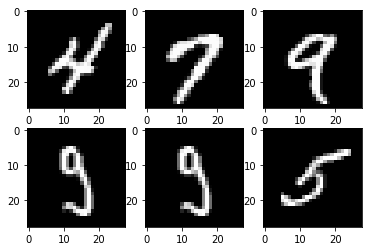

In [6]:
# Data utilities and training images display
X_train, y_train, X_test, y_test = LoadData_PreProcess()
n_classes = y_test.shape[1]
print(y_train.shape)

# 1. Attacking an ML-model

In this section, we implement an attack ourselves. We then leverage the Cleverhans library to craft adversarial examples. First, however, you need a model you can attack. Feel free to choose the DNN/ConvNN from your last project.

Hint: you might want to save the trained model to save time later.

### 1.1.1: Setting up the model (5 Points)

Re-use the model from your last project here and train it until it achieves reasonable accuracy (>92%).

In [7]:
for file in os.listdir('.'):
    #print(file)
    if 'cnn_mnist.h5' in os.listdir('.'):
        model = load_model('cnn_mnist.h5')
        TRAIN = False
        break
    else:
        TRAIN = True
print("Model was loaded:", not(TRAIN))

Model was loaded: True


In [8]:

def CNN_model(no_filters = 32, filter_size=(5,5), activation = 'relu', optimizer_algo = 'adam', dropout=0.0):
  # create model
    model = Sequential()
    # Convolution layer
    model.add(Conv2D(filters=no_filters, kernel_size=filter_size, input_shape=(1, 28, 28), activation= activation))
    # Pooling layer
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # Drop out 
    model.add(Dropout(dropout))
    # Flattening into a single vector
    model.add(Flatten())
    # Fully connected layer
    model.add(Dense(128, activation=activation))
    # output layer
    model.add(Dense(n_classes, activation='softmax'))
    # Compile model|
    if(optimizer_algo == 'adam'):
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    elif(optimizer_algo == 'sgd'):
        model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

    return model

In [9]:
# build the model
# activation': 'relu', 'batch_size': 200, 'dropout': 0.5, 'epochs': 30, 'filter_size': (5, 5), 'no_filters': 32, 'optimizer_algo': 'adam'
if TRAIN == True:
    model = CNN_model(no_filters = 32,\
                      filter_size=(5, 5),\
                      activation = 'relu',\
                      optimizer_algo = 'adam',\
                      dropout=0.5)

    # Fit the model 
    fit_model_final = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=30, batch_size=200, verbose=1)
    # Final evaluation of the model
    scores = model.evaluate(X_test, y_test, verbose=1)
    print("CNN Error: %.2f%%" % (100-scores[1]*100))
    model.save('cnn_mnist.h5')

Train on 60000 samples, validate on 10000 samples
Epoch 1/30
60000/60000 [==============================] - 77s 1ms/step - loss: 0.2840 - acc: 0.9163 - val_loss: 0.0932 - val_acc: 0.9723
Epoch 2/30
60000/60000 [==============================] - 76s 1ms/step - loss: 0.0991 - acc: 0.9697 - val_loss: 0.0580 - val_acc: 0.9810
Epoch 3/30
60000/60000 [==============================] - 78s 1ms/step - loss: 0.0754 - acc: 0.9765 - val_loss: 0.0458 - val_acc: 0.9852
Epoch 4/30
60000/60000 [==============================] - 91s 2ms/step - loss: 0.0616 - acc: 0.9809 - val_loss: 0.0415 - val_acc: 0.9866
Epoch 5/30
60000/60000 [==============================] - 89s 1ms/step - loss: 0.0517 - acc: 0.9838 - val_loss: 0.0369 - val_acc: 0.9883
Epoch 6/30
60000/60000 [==============================] - 89s 1ms/step - loss: 0.0433 - acc: 0.9864 - val_loss: 0.0372 - val_acc: 0.9871
Epoch 7/30
60000/60000 [==============================] - 90s 1ms/step - loss: 0.0403 - acc: 0.9873 - val_loss: 0.0337 - val_acc

In [9]:

K.set_learning_phase(False)


In [10]:
# Subset training data, taking 1st instance of each digit. Visualize them. Run model. Show output.
idx_list = []
for i in range(10):
    idx_list.append((np.where(y_trainval==i)[0][0],i))

X_sample_list = []
Y_sample_list = []
for tup in idx_list:
    idx, lab = tup[0], tup[1]
    X_sample_list.append(x_trainval[idx])
    Y_sample_list.append(lab)
#plt.imshow(X_sample_list[0], cmap=plt.get_cmap('gray'))
Y_sample_list = np_utils.to_categorical(Y_sample_list)
X_sample_list = np.array(X_sample_list)
X_sample_list = X_sample_list.reshape(X_sample_list.shape[0], 1, 28, 28).astype('float32')
#print(Y_sample_list[0])

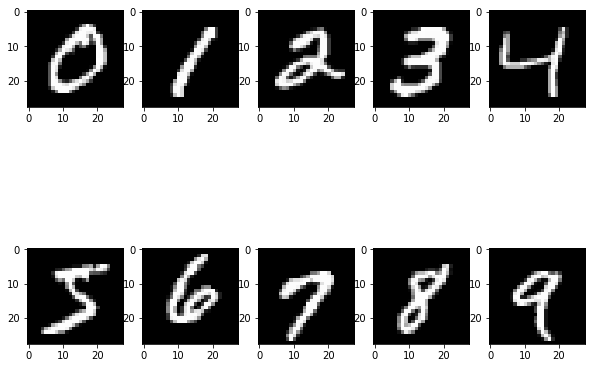

In [11]:
# Visualize all the subset digits
def visualize_sample_digits(digit_feats):
    for i in range(len(digit_feats)):
        plt.rcParams['figure.figsize'] = (10.0, 8.0)
        img = np.squeeze(digit_feats[i])
        plt.subplot(2, 5, i+1)
        plt.imshow(img, cmap=plt.get_cmap('gray'))
    

visualize_sample_digits(X_sample_list)

In [12]:
# Model prediction on these 10 digits.
y_pred = model.predict(X_sample_list)
y_pred_labels = np.argmax(y_pred, axis=1)
print("True labels:", list(np.argmax(Y_sample_list, axis=1)))
print("Predicted labels:",list(y_pred_labels))

True labels: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Predicted labels: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


### 1.1.2: Implementing an attack (20 Points)

We now want you to attack the model trained in the previous step. You are free to choose any attack from the lecture, or implement your own idea. Take into account that the attacker is stealhy and wants to remain undetected: introduce a small change only! To test your attack, craft one adversarial example for the first occurence of each digit class in the training data.

In [13]:
def find_adversary_noise(X_sample_list, alpha = 0.35, max_iters=5):
    adv_sample_list = []
    for sample in X_sample_list:    
        sample = sample.reshape(1, 1, 28, 28)
        
        sample = sample/255
        noisy_image = sample
        for i in range(max_iters):
            #print("Iteration:",i)
            gradient = K.gradients((K.dot(model.layers[-1].input,model.layers[-1].kernel)+model.layers[-1].bias), model.input)
            sess = K.get_session()
            eval_grad = sess.run(gradient, feed_dict = {model.input: noisy_image})
            eval_grad = np.squeeze(eval_grad)

            noisy_image=sample + alpha*np.sign(eval_grad)
            noisy_image = np.clip(noisy_image, a_min=0, a_max=1)
            
        adv_sample_list.append(noisy_image.squeeze())
    print("Done!")    
    return adv_sample_list

In [14]:
noisy_img_list = find_adversary_noise(X_sample_list)

Done!


### 1.1.3: Visualizing the results (5 Points)

Please visualize the ten adversarial examples you crafted in the previous step.

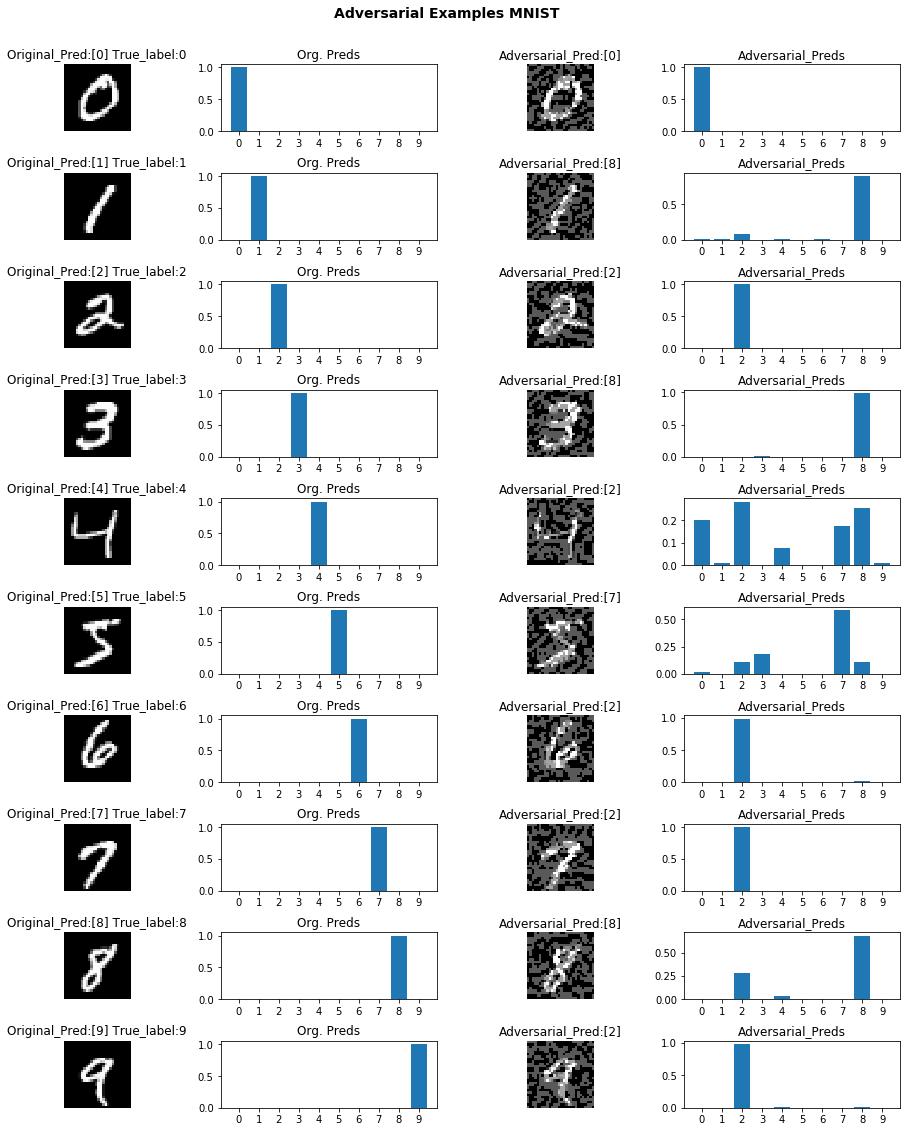

In [15]:
Y_label_list = np.argmax(Y_sample_list, 1)
visualize_digits(10, X_sample_list, noisy_img_list, Y_label_list, model, "Adversarial Examples MNIST")

### 1.2.1: Using libraries for attacks (20 Points)
As the field of evasion attacks (in particular for DNN) is very active research field, several libraries have been published that contain attacks. We will work here with the CleverHans (https://github.com/tensorflow/cleverhans) library. Please implement FGSM and another attack of your choice using this library. Please plot for both attacks the resulting adversarial examples as before, craft however a bigger set of at least 1,000 examples using FGSM. 

## Subset 1000 images to generate adversarial examples.

In [16]:
# Subset 100 from each label from the training set.
#print(np.argmax(y_train[1]))
import random
seed = 21
np.random.seed = 21
dict_nums = {}
for i in range(len(X_train)):
    label = np.argmax(y_train[i])
    if label not in dict_nums:
        dict_nums[label] = [i]
    else:
        dict_nums[label].append(i)
#print(dict_nums)
X_subset = None
y_subset = None
for num in dict_nums:
    idxs = dict_nums[num]
    sub = random.sample(idxs, 100)
    if X_subset is None:
        X_subset = X_train[sub]
        y_subset = y_train[sub]
    else:
        X_subset = np.append(X_subset, X_train[sub], axis=0)
        y_subset = np.append(y_subset, y_train[sub], axis=0)
    
print(X_subset.shape)
print(y_subset.shape)

(1000, 1, 28, 28)
(1000, 10)


Test accuracy: 100.00%
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       100
           1       1.00      1.00      1.00       100
           2       1.00      1.00      1.00       100
           3       1.00      1.00      1.00       100
           4       1.00      1.00      1.00       100
           5       1.00      1.00      1.00       100
           6       1.00      1.00      1.00       100
           7       1.00      1.00      1.00       100
           8       1.00      1.00      1.00       100
           9       1.00      1.00      1.00       100

   micro avg       1.00      1.00      1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000

Confusion Matrix:
 [[100   0   0   0   0   0   0   0   0   0]
 [  0 100   0   0   0   0   0   0   0   0]
 [  0   0 100   0   0   0   0   0   0   0]
 [  0   0   0 100   0   0   0   0   0   0]
 [ 

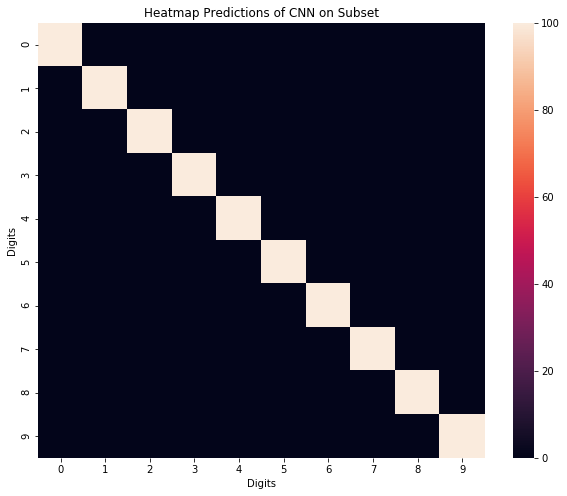

In [17]:
tf.set_random_seed(1234)

sess = K.get_session()

y_pred = model.predict(X_subset)
y_pred_label = np.argmax(y_pred, axis=1)
y_test_label = np.argmax(y_subset, axis=1)
display_classification_results(y_test_label, y_pred_label,"Heatmap Predictions of CNN on Subset")

## Attack 1: Fast Gradient Sign Method

In [18]:
wrapper = KerasModelWrapper(model)
fgsm = FastGradientMethod(wrapper, sess=sess)
fgsm_params = {'eps': 0.23,
               'clip_min': 0.,
               'clip_max': 1.}
adv_X_fgsm = fgsm.generate_np(X_subset, **fgsm_params)

[INFO 2018-12-09 21:24:52,148 cleverhans] Constructing new graph for attack FastGradientMethod


Test accuracy: 31.40%
Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.68      0.70       100
           1       0.51      0.24      0.33       100
           2       0.49      0.56      0.52       100
           3       0.24      0.23      0.24       100
           4       0.22      0.35      0.27       100
           5       0.31      0.34      0.33       100
           6       0.43      0.16      0.23       100
           7       0.25      0.17      0.20       100
           8       0.20      0.38      0.26       100
           9       0.03      0.03      0.03       100

   micro avg       0.31      0.31      0.31      1000
   macro avg       0.34      0.31      0.31      1000
weighted avg       0.34      0.31      0.31      1000

Confusion Matrix:
 [[68  0 12  0  0  4  7  2  4  3]
 [ 0 24  4  2 29  0  1 17 23  0]
 [ 2  4 56  5  2  1  1 15 14  0]
 [ 1  1  7 23  0 19  0  3 31 15]
 [ 0  2  4  0 35  2  2  6 23 26]
 [ 1  0  1 

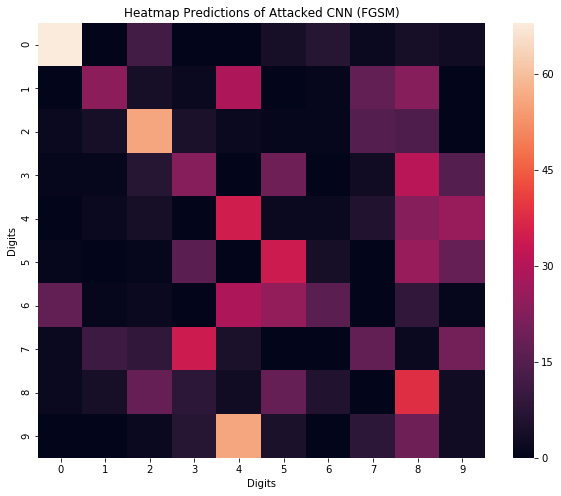

In [19]:
y_pred_adv = model.predict(adv_X_fgsm)
y_pred_adv_label = np.argmax(y_pred_adv, axis=1)
y_test_label = np.argmax(y_subset, axis=1)
display_classification_results(y_test_label, y_pred_adv_label,"Heatmap Predictions of Attacked CNN (FGSM)")

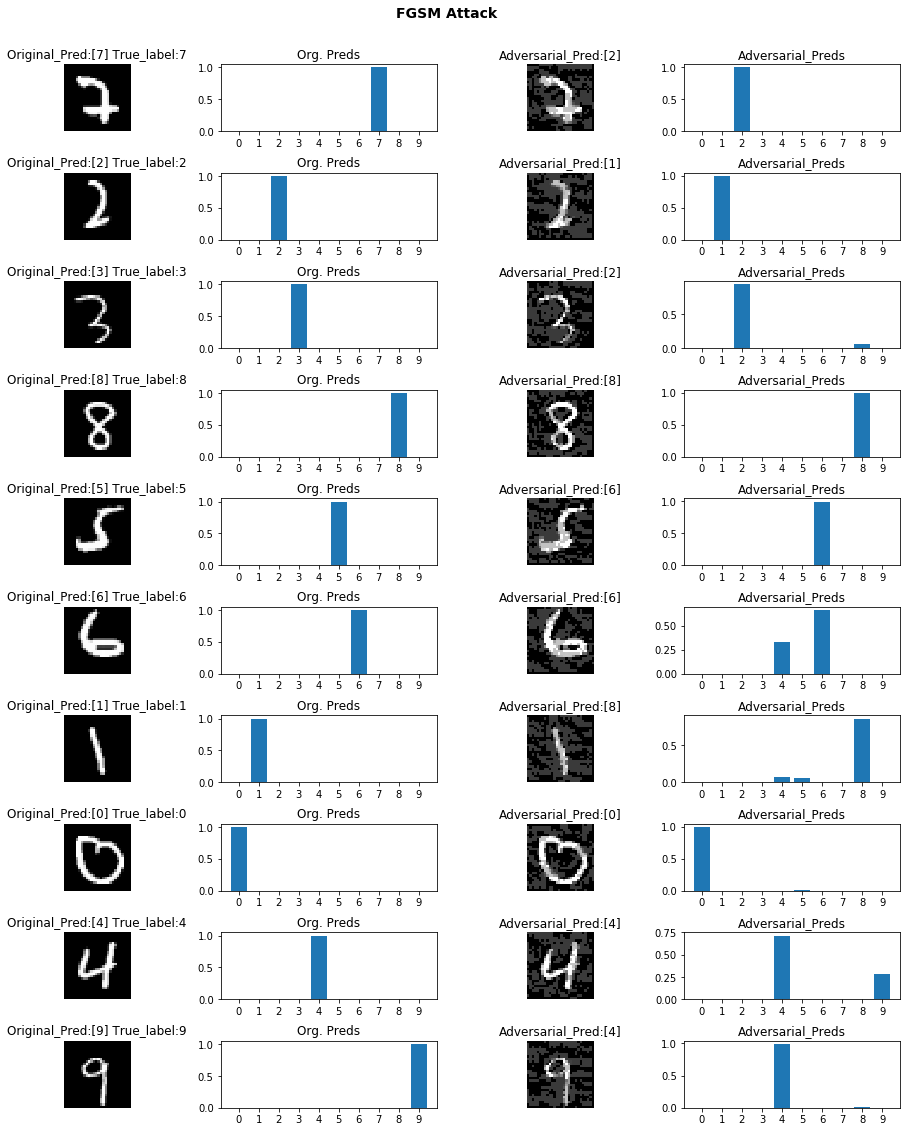

In [20]:

visualize_digits(10, X_subset, adv_X_fgsm, y_test_label, model, 'FGSM Attack')

## Attack: 2 Momentum Iterative Method (MIM)

In [21]:
wrapper = KerasModelWrapper(model)
sess = K.get_session()
mim = MomentumIterativeMethod(wrapper, sess=sess)
mim_params = {
              'eps_iter': 0.03,
              'nb_iter': 10,
              'clip_min': 0.,
              'clip_max': 1.}
adv_X_mim = mim.generate_np(X_subset, **mim_params)

[INFO 2018-12-09 21:25:02,311 cleverhans] Constructing new graph for attack MomentumIterativeMethod


Test accuracy: 0.60%
Classification Report:
               precision    recall  f1-score   support

           0       0.10      0.03      0.05       100
           1       0.00      0.00      0.00       100
           2       0.03      0.03      0.03       100
           3       0.00      0.00      0.00       100
           4       0.00      0.00      0.00       100
           5       0.00      0.00      0.00       100
           6       0.00      0.00      0.00       100
           7       0.00      0.00      0.00       100
           8       0.00      0.00      0.00       100
           9       0.00      0.00      0.00       100

   micro avg       0.01      0.01      0.01      1000
   macro avg       0.01      0.01      0.01      1000
weighted avg       0.01      0.01      0.01      1000

Confusion Matrix:
 [[ 3  1 32  1  0  5 31  4  7 16]
 [ 0  0  4  2 42  0  4 17 31  0]
 [ 1 15  3 10  4  2  1 42 22  0]
 [ 1  1  7  0  1 24  0  3 38 25]
 [ 0  6  6  1  0  3  2 10 32 40]
 [ 1  0  2 1

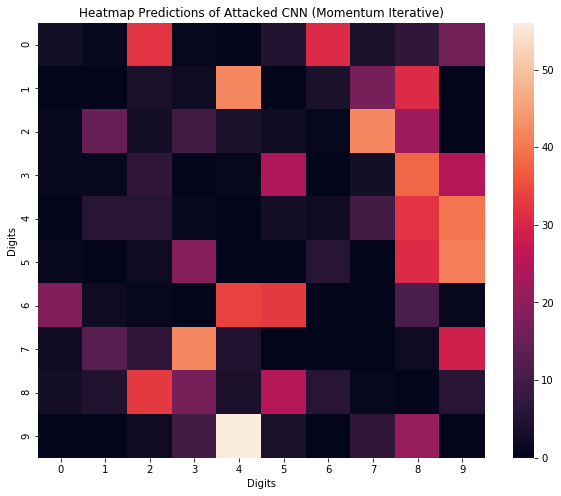

In [22]:
y_pred_adv_2 = model.predict(adv_X_mim)
y_pred_adv_label_2 = np.argmax(y_pred_adv_2, axis=1)
y_test_label = np.argmax(y_subset, axis=1)
display_classification_results(y_test_label, y_pred_adv_label_2,"Heatmap Predictions of Attacked CNN (Momentum Iterative)")

### 1.2.2: Visualizing the results (10 Points)
As before, please plot the results from the previous steps. Compare the results to your own attack. Which differences do you observe between the attacks? Why?

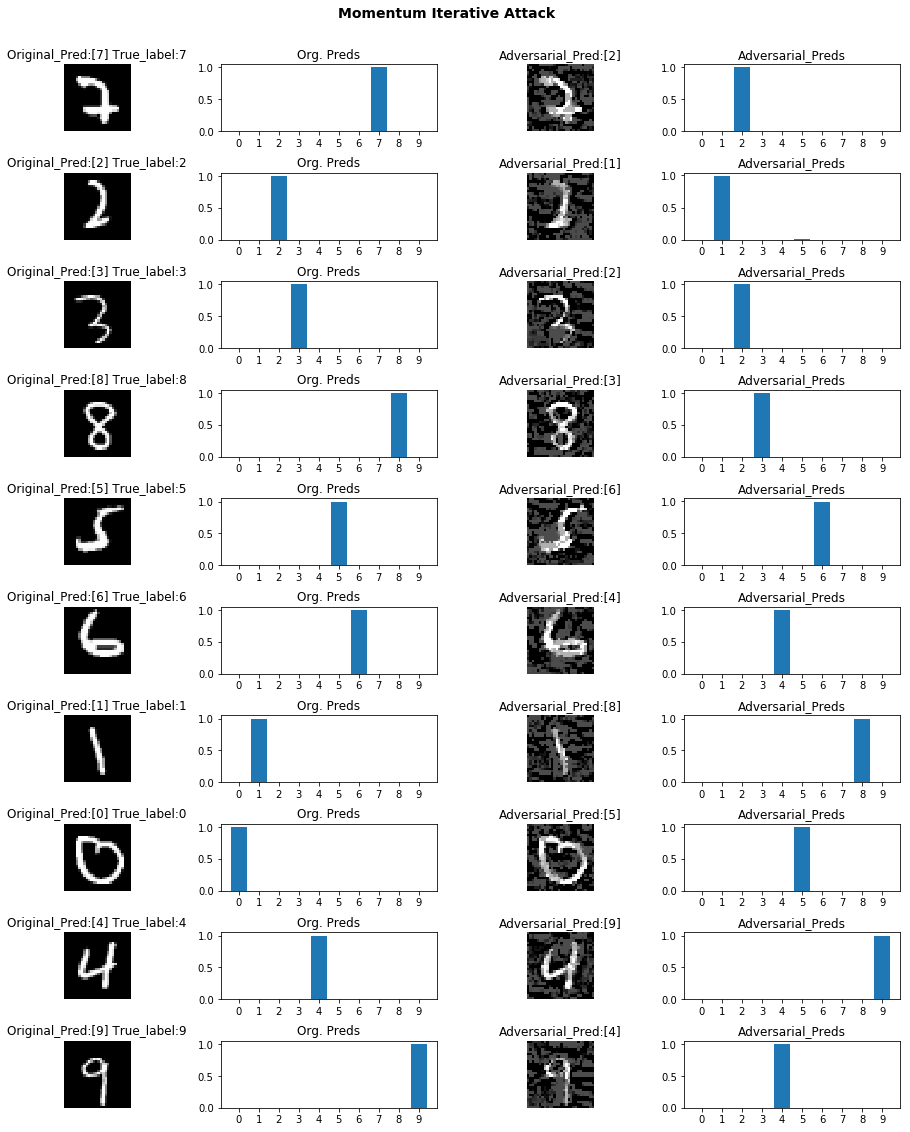

In [23]:
visualize_digits(10, X_subset, adv_X_mim, y_test_label, model, "Momentum Iterative Attack")

- We can see that the adversarial examples generated by us, and those by CleverHans had different output predictions for many of the digits.
- The Momentum Iterative Method managed to fool the model for almost all the examples generated, as it had an accuracy of just 0.6%. FGSM by CleverHans had ~ 32%. Even our hand crafted digits could not fool the model for specific classes (0, 2, 8). Momentum Iterative Method is a much more advanced method of generating adversarial examples, as it improves not only on the FGSM, but also on the Iterative Method as it introduces Momentum optimization. This seems to be a reason behind it's far superior performance.
- The noise level in our examples seem to be slightly more compared to those genereated by CleverHans.

# 2. Defending an ML model

So far, we have focused on attacking an ML model. In this section, we want you to defend your model. As before concerning the attack, you can chose an example from the lecture, or experiment with any idea you have.

We do not require the defense to work perfectly - but what we want you to understand is why it works or why it does not work.

### 2.1: Implementing a defense of your choice (25 Points)
As stated before, feel free to implement a defense or mitigation of your choice. Evaluate the defense on all adversarial examples you obtained from previous steps of this project and report the results.

- **We decide to train our original CNN model with adversarial examples generated by FGSM method. The training is done using CleverHans wrappers.**

In [25]:

# Clone existing model structure to a new graph.
if 'cnn_mnist_def_fgsm.h5' in os.listdir('.'):
    model_2 = load_model('cnn_mnist_def_fgsm.h5')
    TRAIN_ADV = False
else:
    TRAIN_ADV = True
    
print("Adversarially Trained Model loaded:", not(TRAIN_ADV))

Adversarially Trained Model loaded: True


D:\Anaconda3\envs\cysecml\lib\site-packages\keras\engine\saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [90]:
if TRAIN_ADV == True:
    model_2 = clone_model(model)
    wrapper_2 = KerasModelWrapper(model_2)
    sess_2 = K.get_session()
    # FGSM
    fgsm_2 = FastGradientMethod(wrapper_2, sess=sess_2)
    fgsm_params_2 = {'eps': 0.23,
                   'clip_min': 0.,
                   'clip_max': 1.}
    adv_X_2 = fgsm_2.generate_np(X_subset, **fgsm_params_2)

    def fgsm_attack(x):
        return fgsm_2.generate(x, **fgsm_params_2)

    loss_2 = CrossEntropy(wrapper_2, attack=fgsm_attack)

    train_params = {
          'nb_epochs': 30,
          'batch_size': 200,
    }

    train(sess_2, loss_2, X_train, y_train, optimizer=tf.train.AdamOptimizer(), args=train_params)
    model_2.save('cnn_mnist_def_fgsm.h5')

[INFO 2018-12-02 14:33:01,079 cleverhans] Constructing new graph for attack FastGradientMethod
D:\Anaconda3\envs\cysecml\lib\site-packages\cleverhans\loss.py:41: UserWarning: callable attacks are deprecated, switch to an Attack subclass. callable attacks will not be supported after 2019-05-05.
  warnings.warn("callable attacks are deprecated, switch to an Attack "
D:\Anaconda3\envs\cysecml\lib\site-packages\cleverhans\utils_tf.py:511: UserWarning: No GPUS, running on CPU
  warnings.warn("No GPUS, running on CPU")


num_devices:  1


[INFO 2018-12-02 14:35:28,938 cleverhans] Epoch 0 took 144.1934311389923 seconds
[INFO 2018-12-02 14:37:45,463 cleverhans] Epoch 1 took 136.3803174495697 seconds
[INFO 2018-12-02 14:40:02,838 cleverhans] Epoch 2 took 137.25049877166748 seconds
[INFO 2018-12-02 14:42:19,670 cleverhans] Epoch 3 took 136.68637919425964 seconds
[INFO 2018-12-02 14:44:30,697 cleverhans] Epoch 4 took 130.88682222366333 seconds
[INFO 2018-12-02 14:46:45,251 cleverhans] Epoch 5 took 134.417062997818 seconds
[INFO 2018-12-02 14:49:02,418 cleverhans] Epoch 6 took 137.0301058292389 seconds
[INFO 2018-12-02 14:51:19,726 cleverhans] Epoch 7 took 137.1626958847046 seconds
[INFO 2018-12-02 14:53:36,528 cleverhans] Epoch 8 took 136.6744782924652 seconds
[INFO 2018-12-02 14:55:54,177 cleverhans] Epoch 9 took 137.50935745239258 seconds
[INFO 2018-12-02 14:58:10,868 cleverhans] Epoch 10 took 136.54486083984375 seconds
[INFO 2018-12-02 15:00:28,030 cleverhans] Epoch 11 took 137.03275513648987 seconds
[INFO 2018-12-02 15:0

True

Test accuracy: 100.00%
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       100
           1       1.00      1.00      1.00       100
           2       1.00      1.00      1.00       100
           3       1.00      1.00      1.00       100
           4       1.00      1.00      1.00       100
           5       1.00      1.00      1.00       100
           6       1.00      1.00      1.00       100
           7       1.00      1.00      1.00       100
           8       1.00      1.00      1.00       100
           9       1.00      1.00      1.00       100

   micro avg       1.00      1.00      1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000

Confusion Matrix:
 [[100   0   0   0   0   0   0   0   0   0]
 [  0 100   0   0   0   0   0   0   0   0]
 [  0   0 100   0   0   0   0   0   0   0]
 [  0   0   0 100   0   0   0   0   0   0]
 [ 

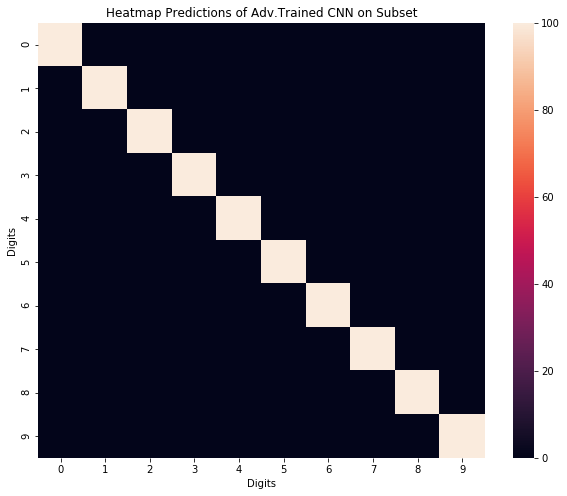

In [26]:
y_pred_2 = model_2.predict(X_subset)
y_pred_label_2 = np.argmax(y_pred_2, axis=1)
y_test_label_2 = np.argmax(y_subset, axis=1)
display_classification_results(y_test_label_2, y_pred_label_2,"Heatmap Predictions of Adv.Trained CNN on Subset")

## Check performance on the custom generated images.

Test accuracy: 60.00%
Confusion Matrix:
 [[1 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 1 0 0 0 0 0]]


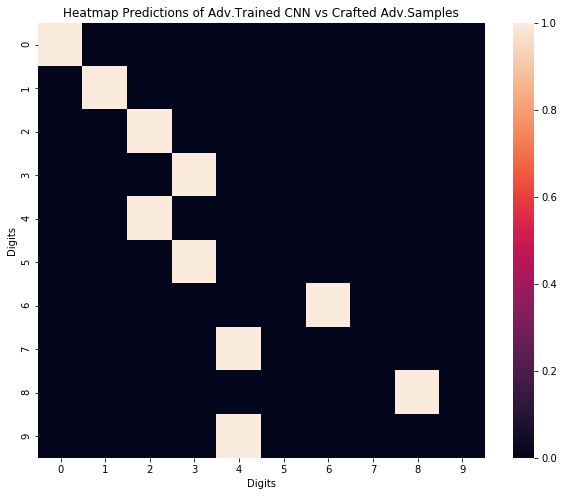

In [27]:
noisy_img_list = np.array(noisy_img_list)
y_pred_3 = model_2.predict(noisy_img_list.reshape((noisy_img_list.shape[0],1,28,28)))
y_pred_label_3 = np.argmax(y_pred_3, axis=1)
y_test_label_3 = Y_label_list
display_classification_results(y_test_label_3, y_pred_label_3,"Heatmap Predictions of Adv.Trained CNN vs Crafted Adv.Samples", show_report=False)

## Check performance on the FGSM generated images.

Test accuracy: 93.40%
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.98      0.95       100
           1       0.96      0.99      0.98       100
           2       0.93      0.97      0.95       100
           3       0.86      0.96      0.91       100
           4       0.96      0.91      0.93       100
           5       0.97      0.86      0.91       100
           6       0.92      0.97      0.95       100
           7       0.97      0.92      0.94       100
           8       0.93      0.85      0.89       100
           9       0.92      0.93      0.93       100

   micro avg       0.93      0.93      0.93      1000
   macro avg       0.94      0.93      0.93      1000
weighted avg       0.94      0.93      0.93      1000

Confusion Matrix:
 [[98  0  0  0  0  1  0  0  1  0]
 [ 0 99  0  0  1  0  0  0  0  0]
 [ 1  0 97  1  0  0  0  0  1  0]
 [ 0  1  0 96  0  0  1  0  2  0]
 [ 1  0  0  0 91  0  0  3  0  5]
 [ 1  0  0 

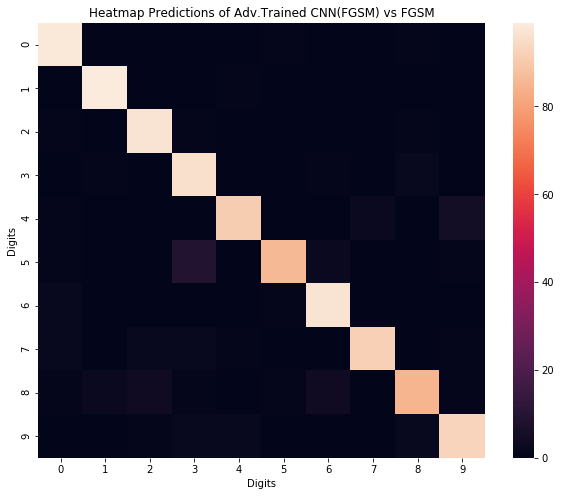

In [28]:
y_pred_adv_2 = model_2.predict(adv_X_fgsm)
y_pred_adv_label_2 = np.argmax(y_pred_adv_2, axis=1)
y_test_label = np.argmax(y_subset, axis=1)
display_classification_results(y_test_label, y_pred_adv_label_2,"Heatmap Predictions of Adv.Trained CNN(FGSM) vs FGSM")

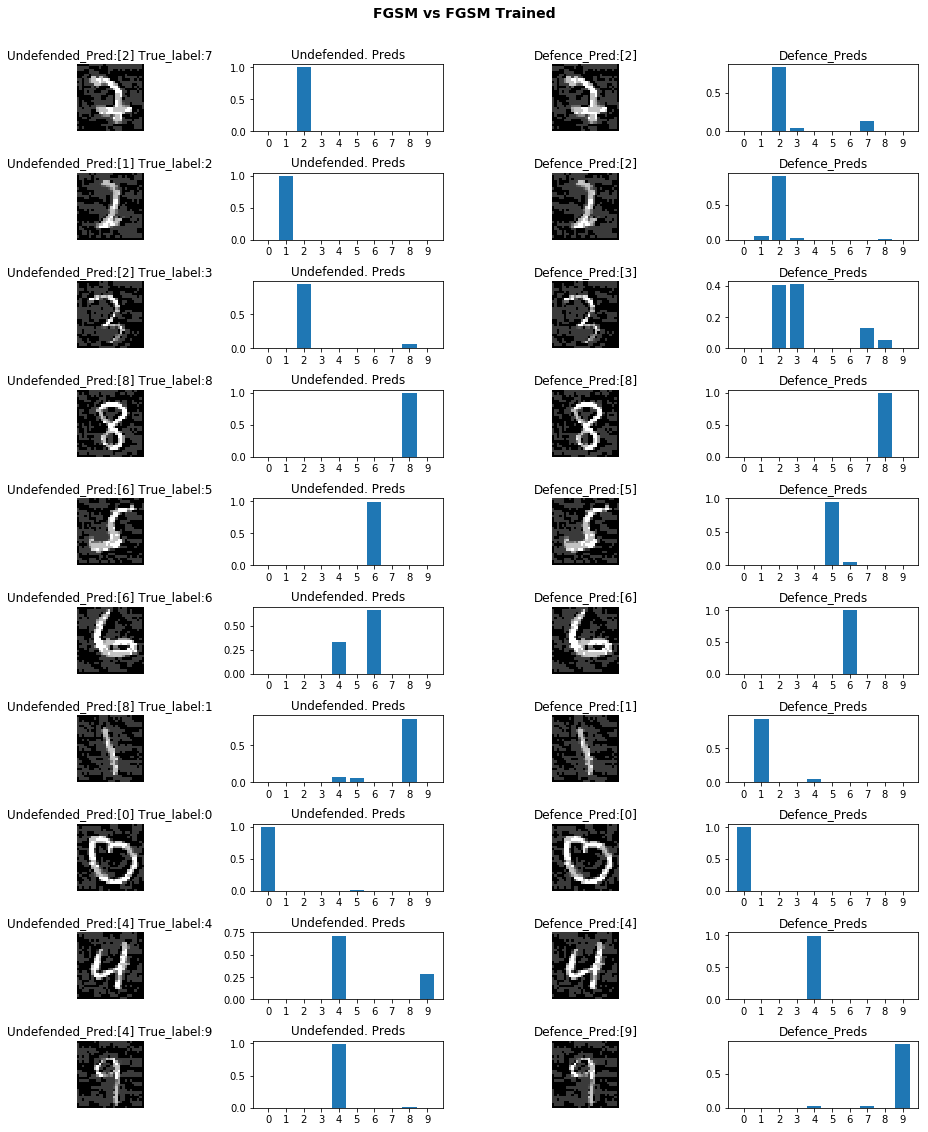

In [29]:
visualize_digits_defended(10, X_subset, adv_X_fgsm, y_test_label, model, model_2, "FGSM vs FGSM Trained")

## Check performance on the previous Momentum Iterative generated images.

Test accuracy: 77.90%
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.97      0.92       100
           1       0.88      0.90      0.89       100
           2       0.77      0.88      0.82       100
           3       0.67      0.74      0.70       100
           4       0.64      0.87      0.74       100
           5       0.74      0.79      0.76       100
           6       0.86      0.83      0.85       100
           7       0.87      0.78      0.82       100
           8       0.71      0.59      0.64       100
           9       0.88      0.44      0.59       100

   micro avg       0.78      0.78      0.78      1000
   macro avg       0.79      0.78      0.77      1000
weighted avg       0.79      0.78      0.77      1000

Confusion Matrix:
 [[97  0  0  1  0  1  0  0  1  0]
 [ 0 90  3  0  4  0  1  0  2  0]
 [ 1  0 88  4  0  1  0  1  5  0]
 [ 0  1  6 74  0  9  1  2  7  0]
 [ 1  1  0  0 87  1  2  3  1  4]
 [ 1  0  0 

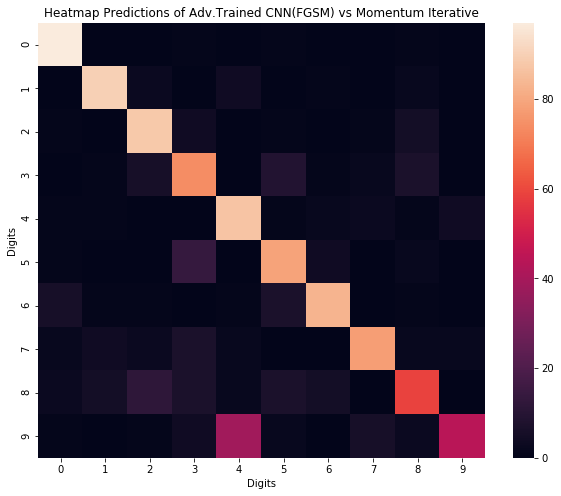

In [30]:
y_pred_adv_2 = model_2.predict(adv_X_mim)
y_pred_adv_label_2 = np.argmax(y_pred_adv_2, axis=1)
y_test_label = np.argmax(y_subset, axis=1)
display_classification_results(y_test_label, y_pred_adv_label_2,"Heatmap Predictions of Adv.Trained CNN(FGSM) vs Momentum Iterative")

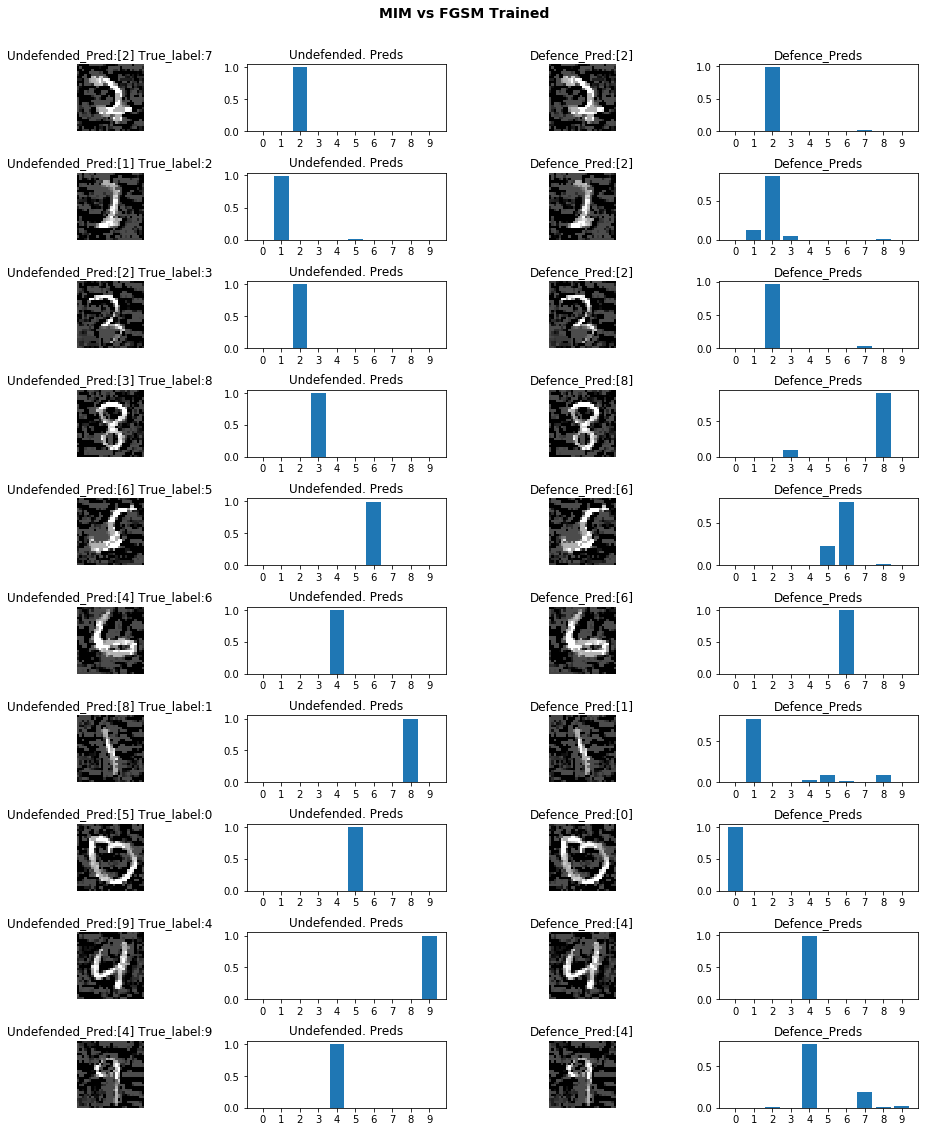

In [31]:
visualize_digits_defended(10, X_subset, adv_X_mim, y_test_label, model, model_2, "MIM vs FGSM Trained")

- It seems that the FGSM defence seems to have improved the model a lot, and made it robust to both attacks.
- But to be certain, we now check the performances by generating adversarial images from the Test Data.

## Check the defended model on test data.

Test accuracy: 99.15%
Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       0.99      1.00      1.00      1135
           2       0.99      1.00      0.99      1032
           3       0.99      1.00      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       0.99      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       1.00      0.98      0.99       974
           9       0.99      0.98      0.98      1009

   micro avg       0.99      0.99      0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000

Confusion Matrix:
 [[ 978    0    0    0    0    1    0    1    0    0]
 [   0 1133    0    0    0    0    1    0    0    1]
 [   1    1 1027    0    0    0    0    3    0    0]
 [   0    0    0 

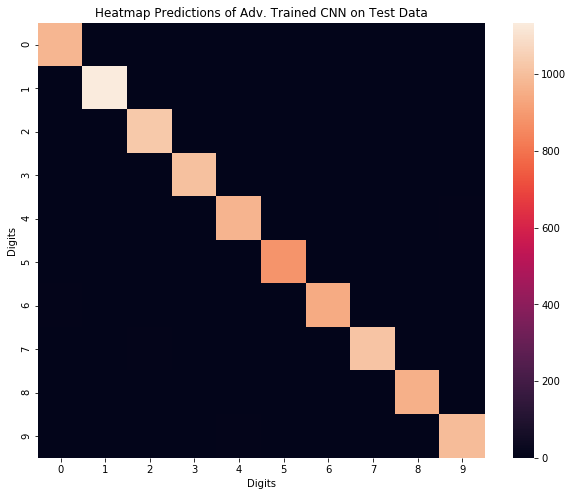

In [27]:
y_pred_test = model_2.predict(X_test)
y_pred_test_label = np.argmax(y_pred_test, axis=1)
y_test_label = np.argmax(y_test, axis=1)
display_classification_results(y_test_label, y_pred_test_label,"Heatmap Predictions of Adv. Trained CNN on Test Data")

- So the performance of the *adversarially trained* model is also very good on unseen unmodified test data.

## Now generate adversarial examples from Test Data. Check the performances of normal model and adversarially trained model.
- Generate adversarial examples on **unseen** data now. 
- Check performance of defended model.

In [28]:
# Subset 100 from each label from the TEST set.

import random
seed = 21
np.random.seed = 21
dict_nums = {}
for i in range(len(X_test)):
    label = np.argmax(y_test[i])
    if label not in dict_nums:
        dict_nums[label] = [i]
    else:
        dict_nums[label].append(i)
#print(dict_nums)
Xtest_subset = None
ytest_subset = None
for num in dict_nums:
    idxs = dict_nums[num]
    sub = random.sample(idxs, 100)
    if Xtest_subset is None:
        Xtest_subset = X_test[sub]
        ytest_subset = y_test[sub]
    else:
        Xtest_subset = np.append(Xtest_subset, X_test[sub], axis=0)
        ytest_subset = np.append(ytest_subset, y_test[sub], axis=0)
    
print(Xtest_subset.shape)
print(ytest_subset.shape)

(1000, 1, 28, 28)
(1000, 10)


## Defended model on the Test subset.

Test accuracy: 99.10%
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99       100
           1       0.99      1.00      1.00       100
           2       1.00      0.99      0.99       100
           3       0.99      1.00      1.00       100
           4       0.99      0.99      0.99       100
           5       0.99      0.99      0.99       100
           6       1.00      0.99      0.99       100
           7       0.96      1.00      0.98       100
           8       1.00      1.00      1.00       100
           9       0.99      0.96      0.97       100

   micro avg       0.99      0.99      0.99      1000
   macro avg       0.99      0.99      0.99      1000
weighted avg       0.99      0.99      0.99      1000

Confusion Matrix:
 [[ 99   0   0   0   0   0   0   1   0   0]
 [  0 100   0   0   0   0   0   0   0   0]
 [  0   0  99   0   0   0   0   1   0   0]
 [  0   0   0 100   0   0   0   0   0   0]
 [  

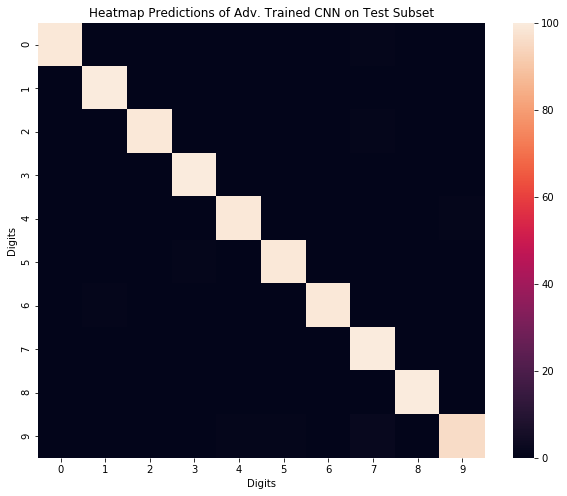

In [29]:
y_pred = model_2.predict(Xtest_subset)
y_pred_label = np.argmax(y_pred, axis=1)
y_test_label = np.argmax(ytest_subset, axis=1)
display_classification_results(y_test_label, y_pred_label,"Heatmap Predictions of Adv. Trained CNN on Test Subset")

## Original model on FGSM (Test data)
- We test the original model (undefended CNN) on FGSM generated images from the Test data.

[INFO 2018-12-09 16:10:16,531 cleverhans] Constructing new graph for attack FastGradientMethod


Test accuracy: 32.00%
Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.68      0.70       100
           1       0.46      0.26      0.33       100
           2       0.49      0.53      0.51       100
           3       0.23      0.23      0.23       100
           4       0.24      0.42      0.30       100
           5       0.25      0.26      0.26       100
           6       0.53      0.19      0.28       100
           7       0.34      0.18      0.24       100
           8       0.22      0.40      0.29       100
           9       0.05      0.05      0.05       100

   micro avg       0.32      0.32      0.32      1000
   macro avg       0.35      0.32      0.32      1000
weighted avg       0.35      0.32      0.32      1000

Confusion Matrix:
 [[68  0  5  1  1  4  7  0  6  8]
 [ 1 26  4  0 31  0  1  4 33  0]
 [ 2 10 53  6  3  0  1 13 12  0]
 [ 1  2 11 23  0 30  0  2 21 10]
 [ 0  2  5  0 42  0  0  6 12 33]
 [ 1  0  1 

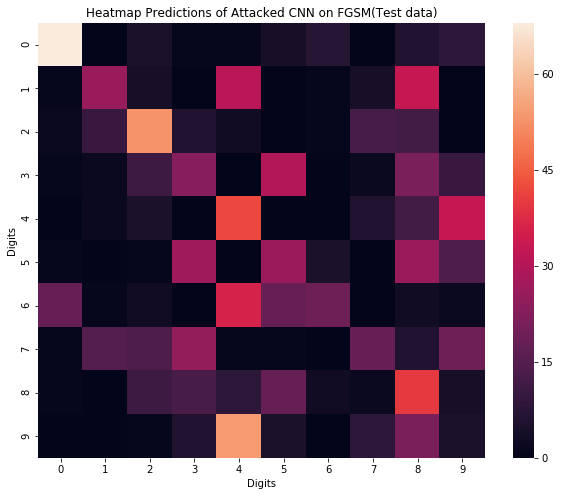

In [30]:
# Let us see how we perform if we generate adversarial examples of test dataset.

wrapper = KerasModelWrapper(model)
fgsm = FastGradientMethod(wrapper, sess=sess)
fgsm_params = {'eps': 0.23,
               'clip_min': 0.,
               'clip_max': 1.}
adv_X = fgsm.generate_np(Xtest_subset, **fgsm_params)

y_pred_adv = model.predict(adv_X)
y_pred_adv_label = np.argmax(y_pred_adv, axis=1)
y_test_label = np.argmax(ytest_subset, axis=1)
display_classification_results(y_test_label, y_pred_adv_label,"Heatmap Predictions of Attacked CNN on FGSM(Test data)")

## Defended model on FGSM (Test data).

Test accuracy: 91.90%
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.97      0.95       100
           1       0.97      0.98      0.98       100
           2       0.95      0.92      0.93       100
           3       0.86      0.91      0.88       100
           4       0.91      0.86      0.88       100
           5       0.95      0.87      0.91       100
           6       0.93      0.99      0.96       100
           7       0.96      0.91      0.93       100
           8       0.95      0.84      0.89       100
           9       0.82      0.94      0.88       100

   micro avg       0.92      0.92      0.92      1000
   macro avg       0.92      0.92      0.92      1000
weighted avg       0.92      0.92      0.92      1000

Confusion Matrix:
 [[97  0  0  0  0  0  2  1  0  0]
 [ 1 98  0  0  0  0  1  0  0  0]
 [ 3  0 92  1  0  0  1  1  2  0]
 [ 1  1  0 91  0  4  1  1  0  1]
 [ 0  0  1  0 86  0  0  0  0 13]
 [ 1  0  0 

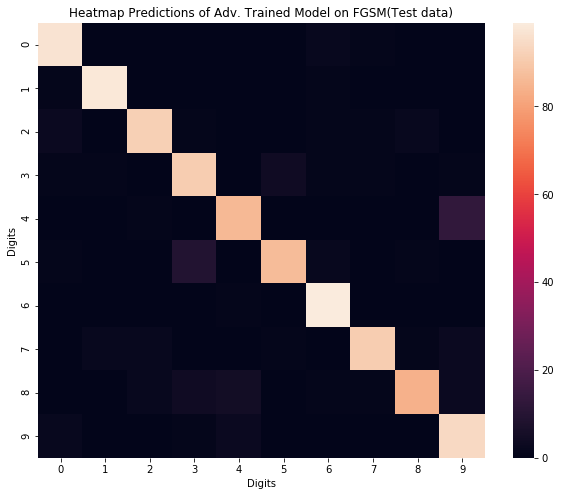

In [31]:
# Now test on the adversarially trained model.
y_pred_adv_2 = model_2.predict(adv_X)
y_pred_adv_label_2 = np.argmax(y_pred_adv_2, axis=1)
y_test_label = np.argmax(ytest_subset, axis=1)
display_classification_results(y_test_label, y_pred_adv_label_2,"Heatmap Predictions of Adv. Trained Model on FGSM(Test data)")

- So the adversarially trained model does respectably even on FGSM images from unseen Test data.

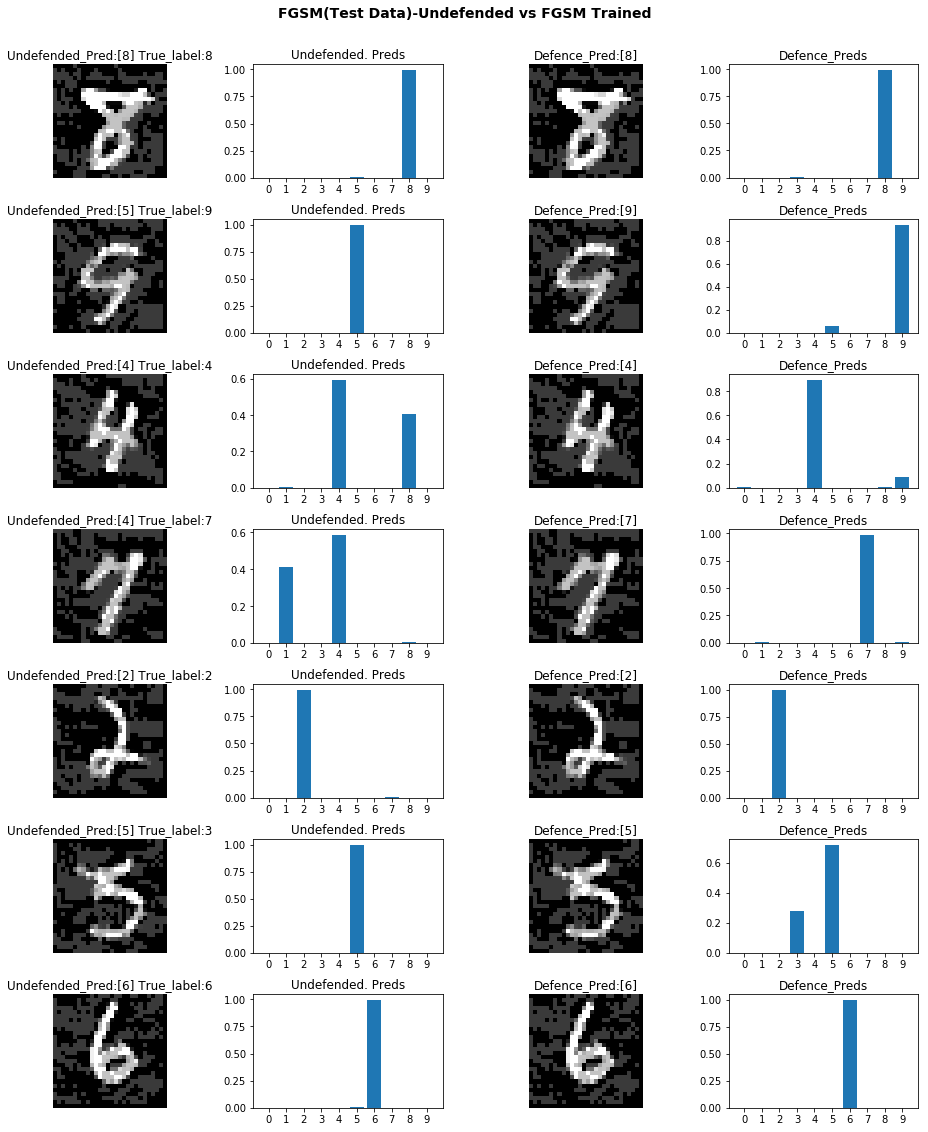

In [32]:
visualize_digits_defended(7, Xtest_subset, adv_X, y_test_label, model, model_2, 'FGSM(Test Data)-Undefended vs FGSM Trained')

## Original model on MIM (Test data).

[INFO 2018-12-09 16:11:39,855 cleverhans] Constructing new graph for attack MomentumIterativeMethod


Test accuracy: 1.10%
Classification Report:
               precision    recall  f1-score   support

           0       0.06      0.02      0.03       100
           1       0.00      0.00      0.00       100
           2       0.03      0.03      0.03       100
           3       0.00      0.00      0.00       100
           4       0.00      0.00      0.00       100
           5       0.01      0.01      0.01       100
           6       0.00      0.00      0.00       100
           7       0.03      0.02      0.02       100
           8       0.00      0.00      0.00       100
           9       0.02      0.03      0.02       100

   micro avg       0.01      0.01      0.01      1000
   macro avg       0.01      0.01      0.01      1000
weighted avg       0.01      0.01      0.01      1000

Confusion Matrix:
 [[ 2  0 17  1  1  7 37  2  8 25]
 [ 1  0  3  0 41  0  1 10 43  1]
 [ 4 23  3  7  6  0  1 33 22  1]
 [ 1  2 11  0  2 37  0  2 25 20]
 [ 0  6  8  0  0  0  0 10 24 52]
 [ 2  0  5 2

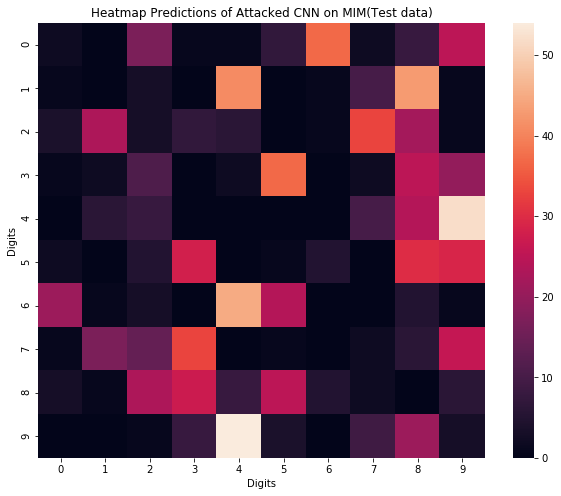

In [34]:
wrapper = KerasModelWrapper(model)

mim = MomentumIterativeMethod(wrapper, sess=sess)
mim_params = {
              'eps_iter': 0.03,
              'nb_iter': 10,
              'clip_min': 0.,
              'clip_max': 1.}
adv_Xtest_mim = mim.generate_np(Xtest_subset, **mim_params)

y_pred_adv = model.predict(adv_Xtest_mim)
y_pred_adv_label = np.argmax(y_pred_adv, axis=1)
y_test_label = np.argmax(ytest_subset, axis=1)
display_classification_results(y_test_label, y_pred_adv_label,"Heatmap Predictions of Attacked CNN on MIM(Test data)")

## Now we check the defended model (defended against FGSM) against MIM on the Test data.

Test accuracy: 76.80%
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.93      0.89       100
           1       0.94      0.92      0.93       100
           2       0.79      0.87      0.83       100
           3       0.60      0.75      0.66       100
           4       0.63      0.83      0.72       100
           5       0.74      0.68      0.71       100
           6       0.87      0.91      0.89       100
           7       0.91      0.79      0.84       100
           8       0.73      0.48      0.58       100
           9       0.68      0.52      0.59       100

   micro avg       0.77      0.77      0.77      1000
   macro avg       0.77      0.77      0.76      1000
weighted avg       0.77      0.77      0.76      1000

Confusion Matrix:
 [[93  0  0  0  0  1  4  1  1  0]
 [ 1 92  2  0  3  0  2  0  0  0]
 [ 3  0 87  4  1  0  1  1  3  0]
 [ 1  1  6 75  0 11  1  1  4  0]
 [ 0  0  1  0 83  0  0  0  0 16]
 [ 3  0  0 

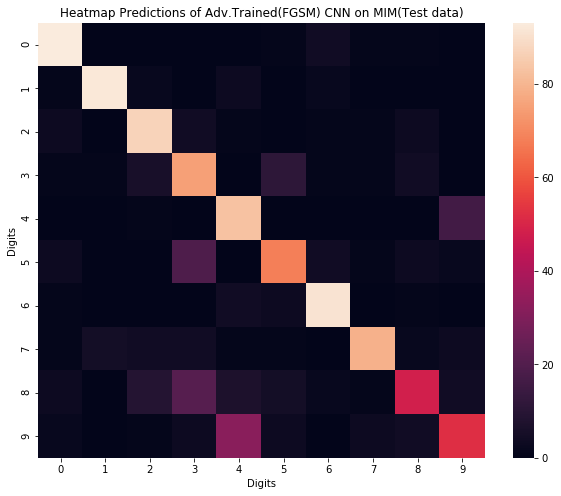

In [35]:

y_pred_adv_2 = model_2.predict(adv_Xtest_mim)
y_pred_adv_label_2 = np.argmax(y_pred_adv_2, axis=1)
y_test_label = np.argmax(ytest_subset, axis=1)
display_classification_results(y_test_label, y_pred_adv_label_2,"Heatmap Predictions of Adv.Trained(FGSM) CNN on MIM(Test data)")

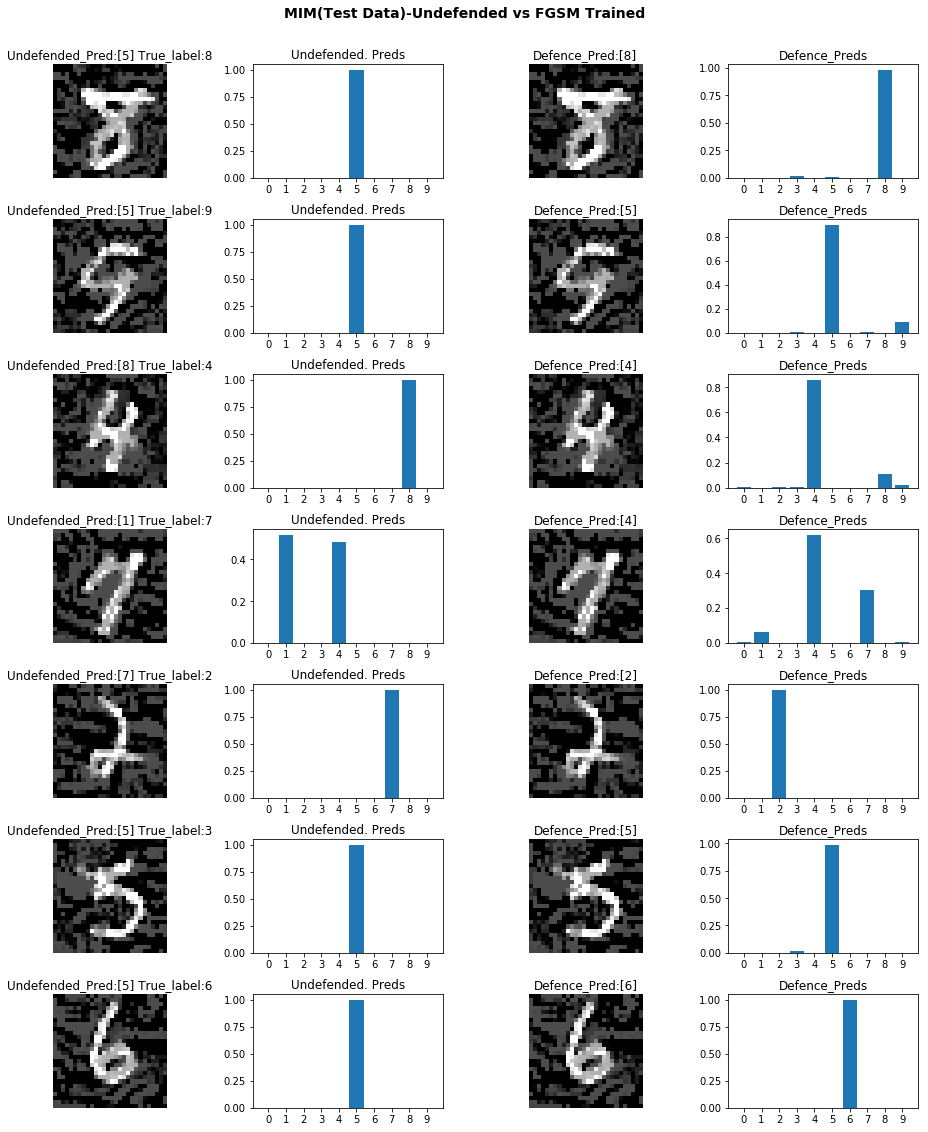

In [36]:
visualize_digits_defended(7, Xtest_subset, adv_Xtest_mim, y_test_label, model, model_2, 'MIM(Test Data)-Undefended vs FGSM Trained')

- So on test data, the defended model does pretty well on both FGSM and MIM attacks. 
- The test accuracy vs FGSM is 92% whereas that against Momentum Iterative (MIM) is around 77%. 
- This could be because our model generated enough adversarial examples to generalize well enough. Even if we defended on just FGSM, it generalized to defend MIM as well, as it got robust to the noise that was being added and adhered more to the actual image pixels to give decisions.

### 2.2: Conclusions (15 Points)
Please interpret the results of your defense here. What did you try to make the classifier more robust? Why did it work? Is the classifier now robust?

Feel free to state any interesting finding you encountered during this project.

- We defended the model by using adverserial training. For adverserial training, we used the FGSM method only. 
- The model has learned to defend against the additional noise becuase of the adverserial training. Because the model can see some adverserially generated images during the training phase. Thus, it has adapted itself.
- Classifier robust? Yes, out classifier has become much more robust because as from the test performed above, the adverserially trained model can predict the FGSM images correctly at around 94% accuracy. Its performance has even improved against the momentum iterative method as the accuracy has increased from 0.6% to 76% -77%.

##### Interesting findings:
- We could see that for FGSM and handcrafted attempt, there are particular image classes that are more robust(for e.g. in FGSM, class 0 was the most robust)
- Even though we used only FGSM training method, performance for the Momentum Iterative Method also improves vastly.